# Import the necessary libraries and read data

In [5]:
# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing and sampling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Modeling and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)

# Model saving and loading
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')
# Read data
df=pd.read_csv('healthcare_dataset_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# Data preprocessing, Building a Random Forest model, Finding the best model and Printing evaluation metrics

In [ ]:
# Handling missing values in 'bmi' column by imputing with the mean value
imputer = SimpleImputer(strategy='mean')
df['bmi'] = imputer.fit_transform(df[['bmi']])

# Select relevant features for the model
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 
            'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
df = df[features + ['stroke']]  # Add 'stroke' as the target variable

# Encode categorical columns using one-hot encoding for categorical features
df = pd.get_dummies(df, drop_first=True)

# Define features (X) and target (y)
X = df.drop(columns=['stroke'])
y = df['stroke']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance the classes (oversample the minority class)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply Random Under-sampling to balance the classes (undersample the majority class)
# Uncomment the following lines if you want to use under-sampling instead of SMOTE
# rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Create RandomForestClassifier model with class_weight='balanced' to handle imbalanced data
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Perform GridSearchCV to find the best hyperparameters for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)  # Train on resampled data

# Best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model's performance
print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Visualizing feature importance from the Random Forest
feature_importance = best_rf.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title('Feature Importance')
plt.show()


Fitting 5 folds for each of 108 candidates, totalling 540 fits


# Save the model

In [ ]:
# Save the trained model to a file
joblib.dump(best_rf, 'random_forest_model.pkl')

# # Load the model from the file
# loaded_model = joblib.load('random_forest_model.pkl')

# # Make predictions with the loaded model
# y_pred_loaded = loaded_model.predict(X_test)
# print("Accuracy of the loaded model:", accuracy_score(y_test, y_pred_loaded))



# Random Forest Visualization

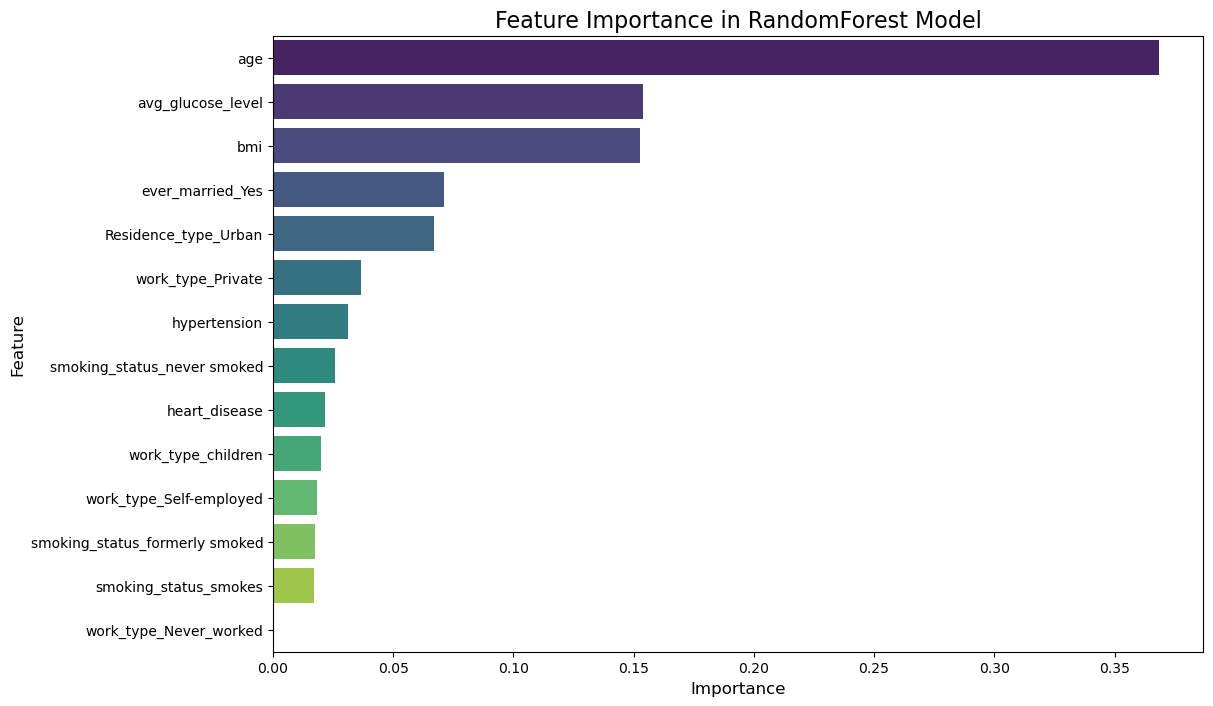

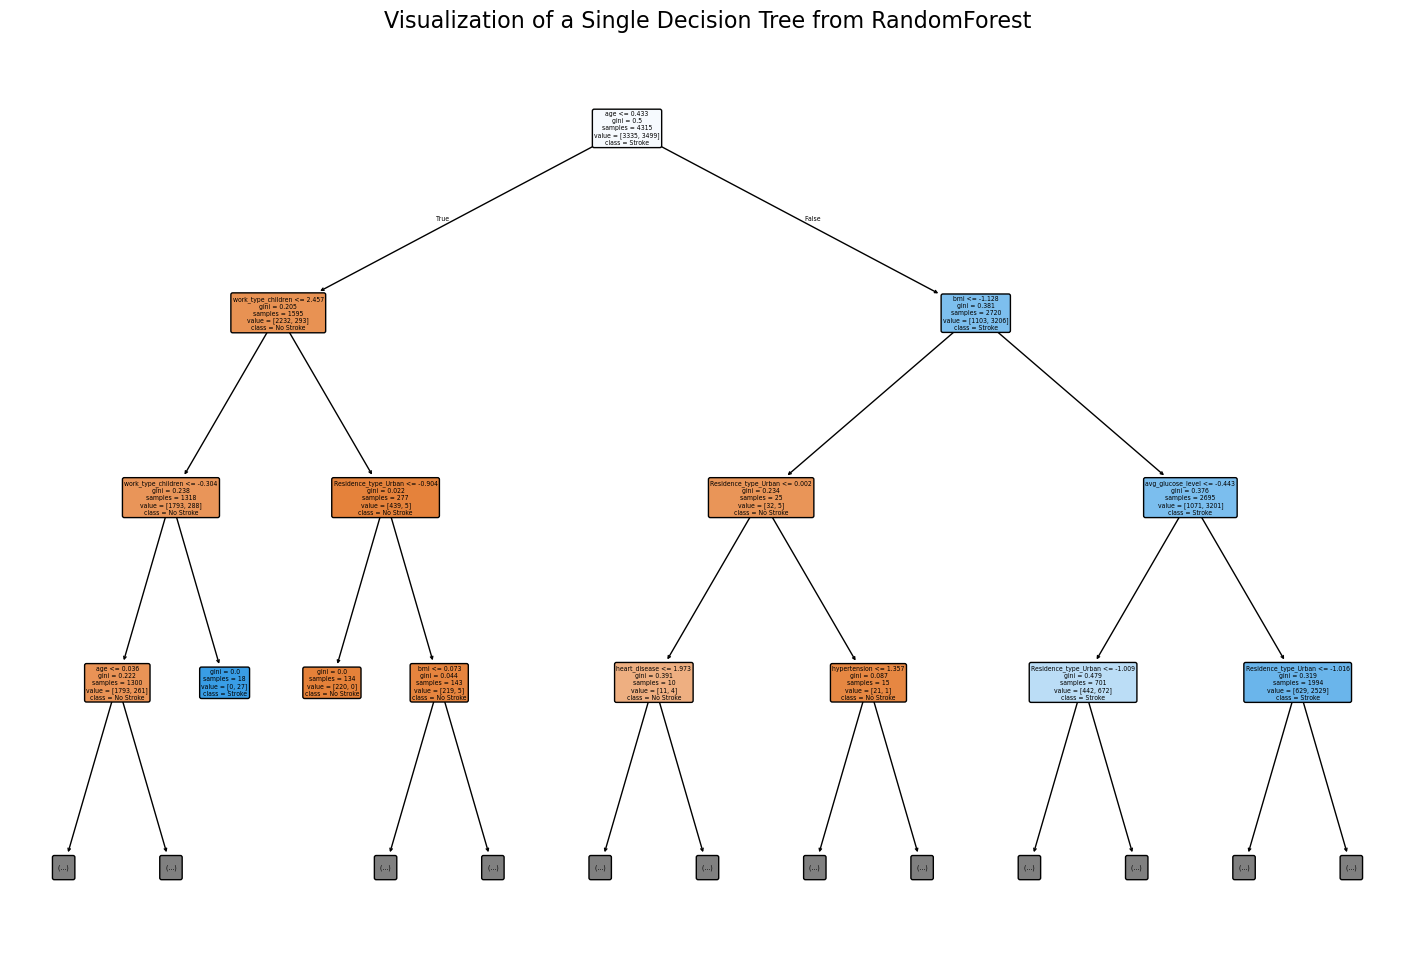

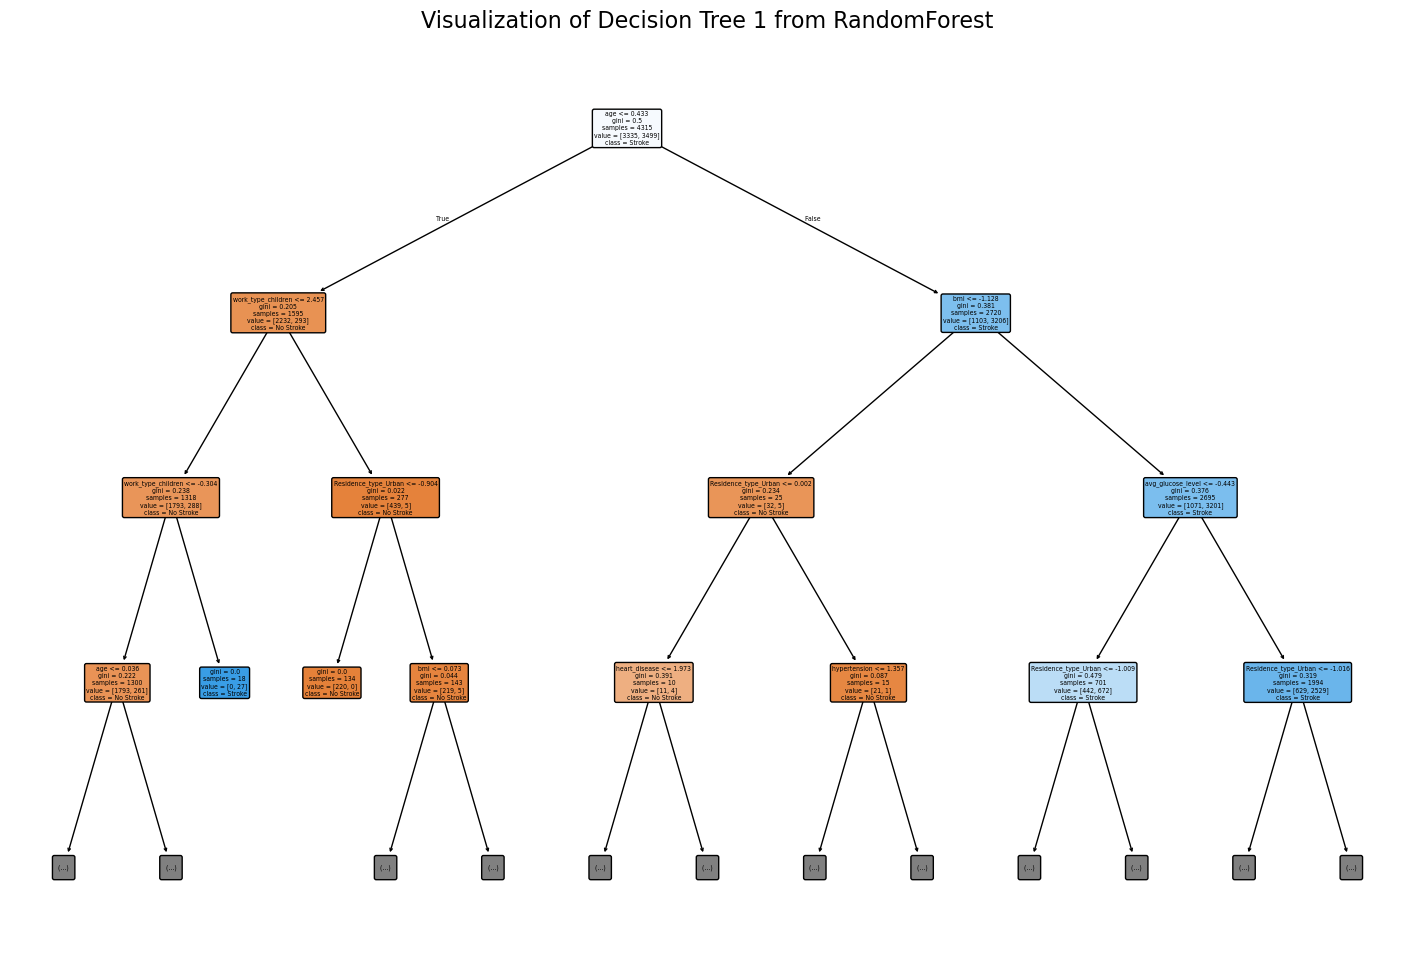

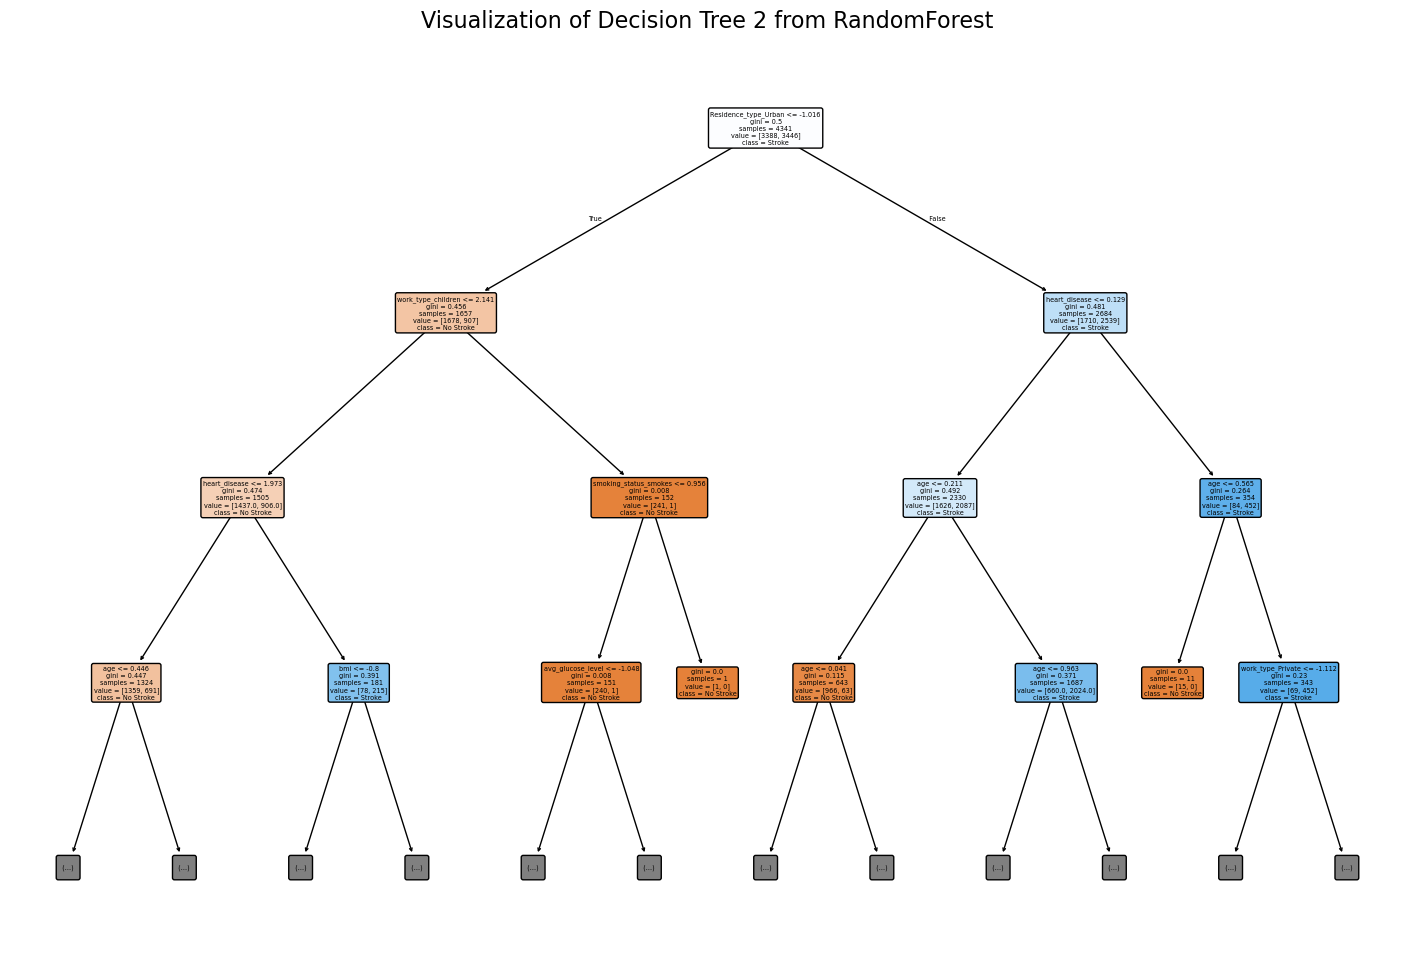

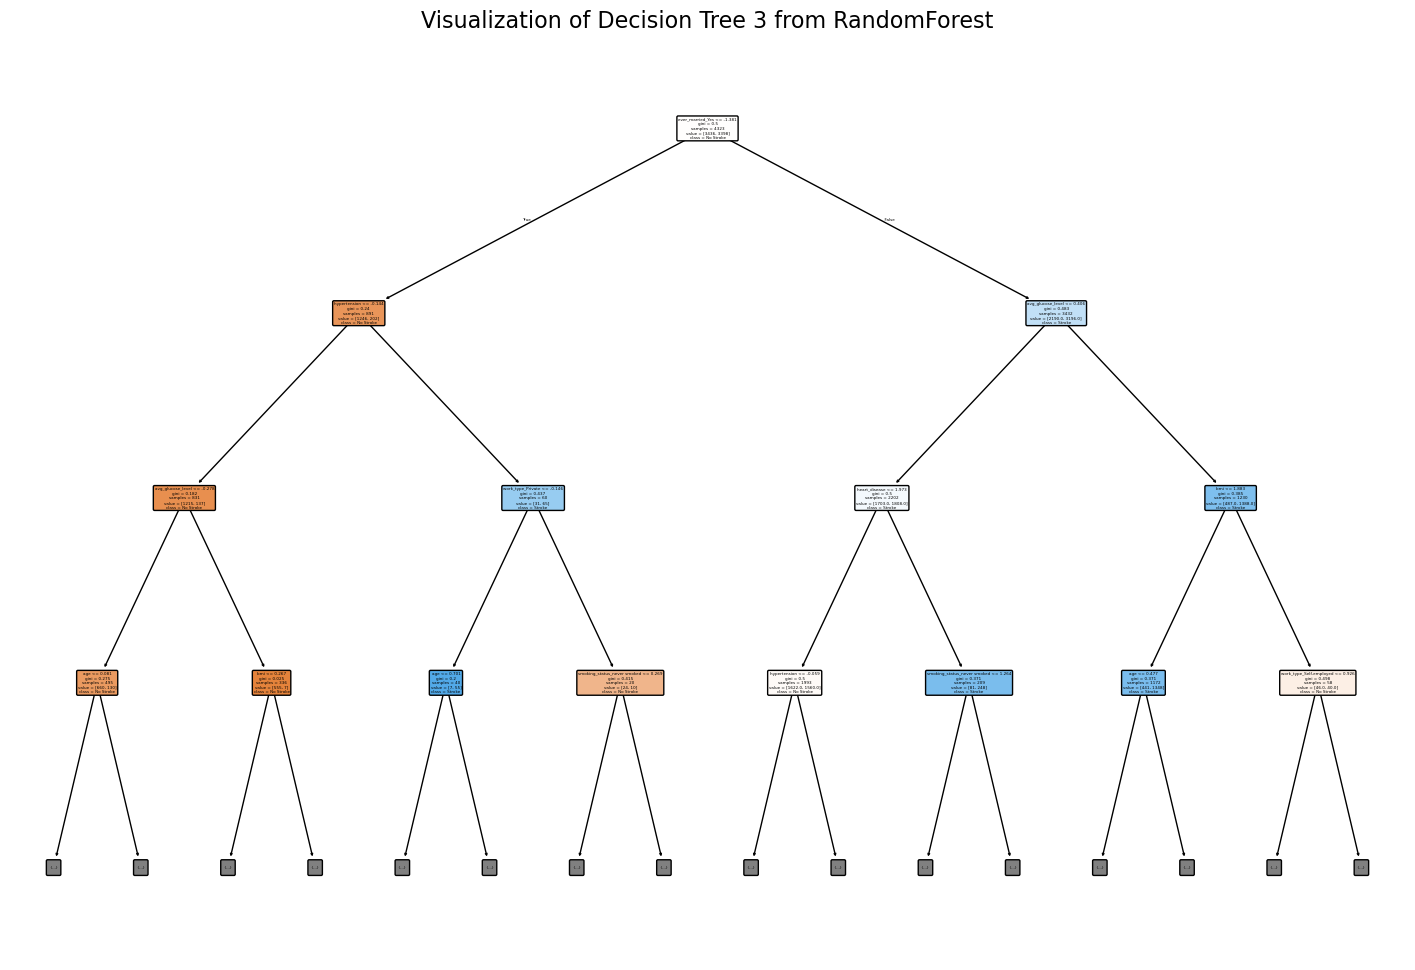

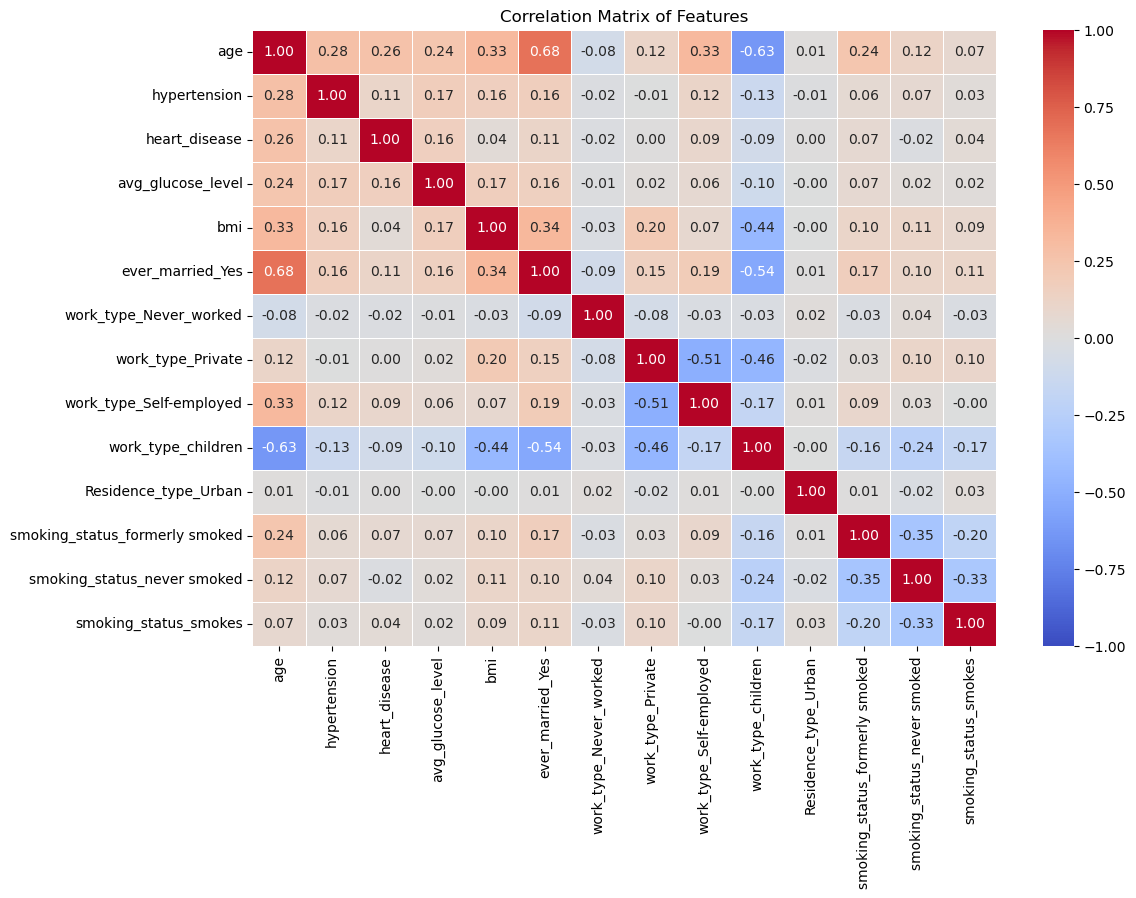

In [4]:
# 1. Visualize Feature Importance
# Get feature importances from the trained RandomForest model
feature_importances = best_rf.feature_importances_

# Create a DataFrame to visualize the feature importances
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')
plt.title('Feature Importance in RandomForest Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# 2. Visualize a single tree from the RandomForest
# Limit the depth of the tree for better readability
plt.figure(figsize=(18, 12))
plot_tree(best_rf.estimators_[0], 
          filled=True, 
          feature_names=X.columns, 
          class_names=['No Stroke', 'Stroke'], 
          rounded=True, 
          max_depth=3)  # Limit depth to 3 for better visualization
plt.title('Visualization of a Single Decision Tree from RandomForest', fontsize=16)
plt.show()

# 3. Plotting multiple decision trees for comparison (optional)
# Let's visualize the first few trees to compare their structures
num_trees_to_plot = 3  # Define how many trees you want to visualize
for i in range(min(num_trees_to_plot, len(best_rf.estimators_))):
    plt.figure(figsize=(18, 12))
    plot_tree(best_rf.estimators_[i], 
              filled=True, 
              feature_names=X.columns, 
              class_names=['No Stroke', 'Stroke'], 
              rounded=True, 
              max_depth=3)  # Limit depth for better readability
    plt.title(f'Visualization of Decision Tree {i+1} from RandomForest', fontsize=16)
    plt.show()

# 4. Visualize the correlation matrix of the features
# Correlation matrix heatmap
# Convert the scaled data back into a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate the correlation matrix
corr_matrix = X_scaled_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

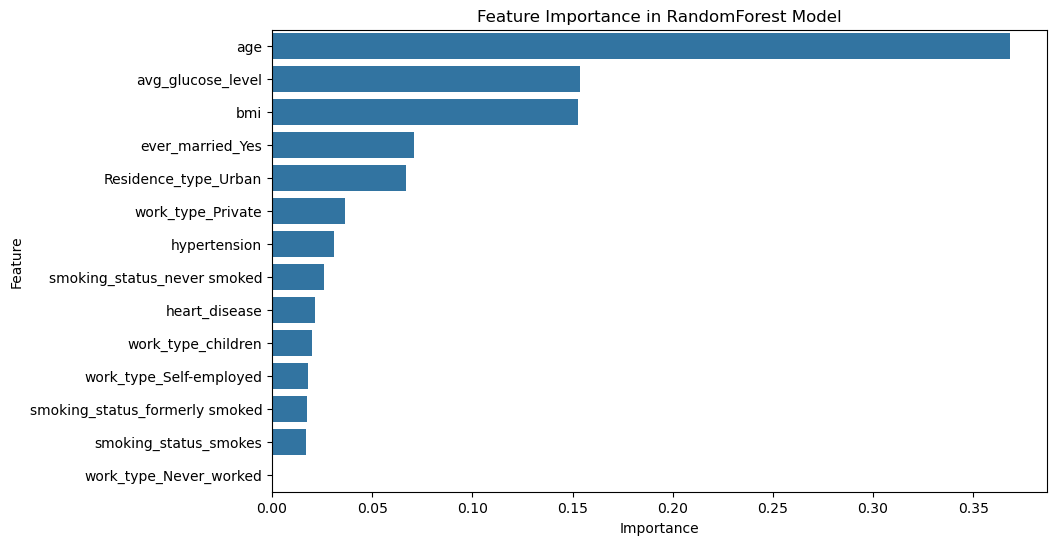

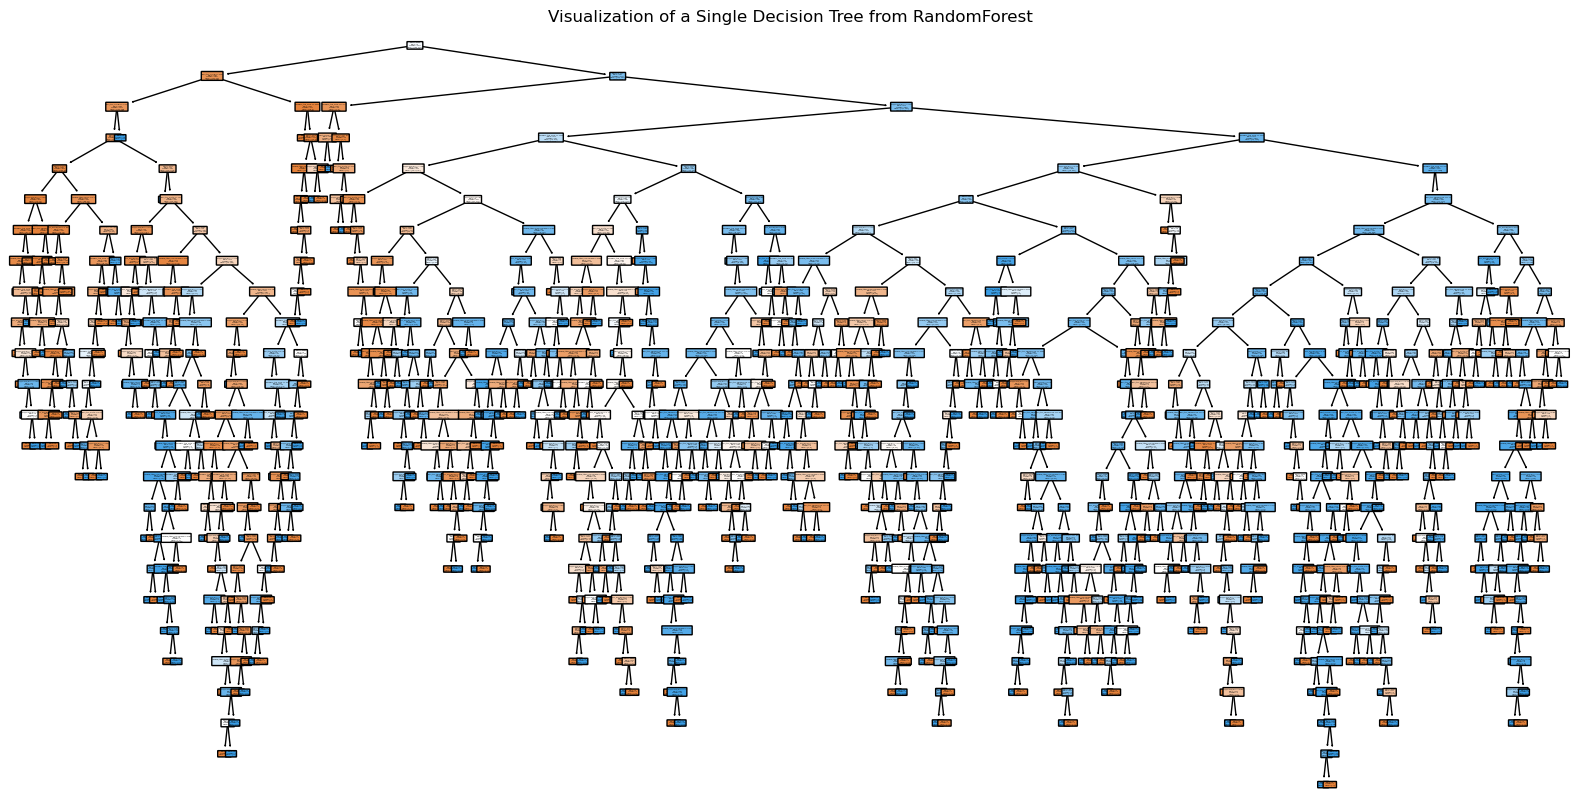

In [5]:
# 1. Visualize Feature Importance
feature_importances = best_rf.feature_importances_

# Create a DataFrame to visualize the feature importances
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance in RandomForest Model')
plt.show()

# 2. Visualize a single tree from the Random Forest
plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0], filled=True, feature_names=X.columns, class_names=['No Stroke', 'Stroke'], rounded=True)
plt.title('Visualization of a Single Decision Tree from RandomForest')
plt.show()
